# Car Price Prediction Project 🚗

## 📚 Table of Contents
1. [Importing Libraries](#importing-libraries)
2. [Data Preprocessing](#data-preprocessing)
3. [EDA](#exploratory-data-analysis-eda)
4. [Model Training](#model-training)
5. [Model Evaluation](#model-evaluation)
6. [Final Summary](#final-summary)
7. [Saving Model](#Saving-the-XGB-Model-to-deploy)

# Importing Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
car = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car details v4.csv')

In [3]:
car.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [4]:
car.rename(columns={'Make': 'Company'}, inplace=True)
car.rename(columns={'Engine': 'Engine_cc'}, inplace=True)

In [5]:
car.shape

(2059, 20)

In [6]:
car.columns

Index(['Company', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type',
       'Engine_cc', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width',
       'Height', 'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')

In [7]:
car = car[['Company', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Engine_cc',
       'Seating Capacity', 'Fuel Tank Capacity']]

In [8]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Company             2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Engine_cc           1979 non-null   object 
 11  Seating Capacity    1995 non-null   float64
 12  Fuel Tank Capacity  1946 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 209.2+ KB


### Handle outliers

In [9]:
# Remove cars with more than 300000 km or more than 12000000 price

car = car[(car['Kilometer'] <= 300000) & (car['Price'] <= 12000000)]
car = car.reset_index(drop=True)

###  Convert Engine_cc dtype to int and handle "cc" at the end

In [10]:
def engine_column(df, col_name='Engine_cc'):
    # Remove 'cc' and strip whitespace
    df[col_name] = df[col_name].str.replace('cc', '', regex=False).str.strip()

    # Convert to numeric, keep NaNs
    df[col_name] = pd.to_numeric(df[col_name])

    # Fill NaNs with median
    df[col_name].fillna(df[col_name].median(), inplace=True)

    # Convert to int
    df[col_name] = df[col_name].astype(int)

    return df

In [11]:
engine_column(car)

,Company,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Engine_cc,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,1198,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,1248,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,1197,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,1197,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,2393,7.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,Mahindra,XUV500 W8 [2015-2017],850000,2016,90300,Diesel,Manual,Surat,White,First,2179,7.0,70.0
2034,Hyundai,Eon D-Lite +,275000,2014,83000,Petrol,Manual,Ahmedabad,White,Second,814,5.0,32.0
2035,Ford,Figo Duratec Petrol ZXI 1.2,240000,2013,73000,Petrol,Manual,Thane,Silver,First,1196,5.0,45.0
2036,BMW,5-Series 520d Luxury Line [2017-2019],4290000,2018,60474,Diesel,Automatic,Coimbatore,White,First,1995,5.0,65.0


### Convert Seating Capacity and Fuel Tank Capacity to int and fill missing values

In [12]:
# Fill missing values with median
car['Seating Capacity'].fillna(car['Seating Capacity'].median(), inplace=True)
car['Fuel Tank Capacity'].fillna(car['Fuel Tank Capacity'].median(), inplace=True)

# Convert to integer type
car['Seating Capacity'] = car['Seating Capacity'].astype(int)
car['Fuel Tank Capacity'] = car['Fuel Tank Capacity'].astype(int)

### Cleaning the 'Model' column to remove extra junk

In [13]:
def model_name(row):
    company = row['Company'].lower()
    model = row['Model']
    
    # Remove company name from model if present
    model_clean = model.lower().replace(company, '').strip()
    
    # Keep only first 2 words as core model name
    model_words = model_clean.split()
    if len(model_words) >= 2:
        return ' '.join(model_words[:2]).title()
    elif model_words:
        return model_words[0].title()
    else:
        return model.title()  # fallback

# Apply the cleaning
car['Model'] = car.apply(model_name, axis=1)


## Cleaned Data

In [14]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 0 to 2037
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Company             2038 non-null   object
 1   Model               2038 non-null   object
 2   Price               2038 non-null   int64 
 3   Year                2038 non-null   int64 
 4   Kilometer           2038 non-null   int64 
 5   Fuel Type           2038 non-null   object
 6   Transmission        2038 non-null   object
 7   Location            2038 non-null   object
 8   Color               2038 non-null   object
 9   Owner               2038 non-null   object
 10  Engine_cc           2038 non-null   int64 
 11  Seating Capacity    2038 non-null   int64 
 12  Fuel Tank Capacity  2038 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 207.1+ KB


In [15]:
car.describe(include='all')

,Company,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Engine_cc,Seating Capacity,Fuel Tank Capacity
count,2038,2038,2.038000e+03,2038.000000,2038.000000,2038,2038,2038,2038,2038,2038.000000,2038.000000,2038.000000
unique,30,487,NaN,NaN,NaN,9,2,77,17,6,NaN,NaN,NaN
top,Maruti Suzuki,Wagon R,NaN,NaN,NaN,Diesel,Manual,Mumbai,White,First,NaN,NaN,NaN
freq,440,57,NaN,NaN,NaN,1040,1131,339,792,1604,NaN,NaN,NaN
mean,NaN,NaN,1.553457e+06,2016.403337,52945.425417,NaN,NaN,NaN,NaN,NaN,1666.900883,5.300785,51.498528
std,NaN,NaN,1.741208e+06,3.355873,31714.765365,NaN,NaN,NaN,NaN,NaN,589.810125,0.803960,14.407348
min,NaN,NaN,4.900000e+04,1988.000000,0.000000,NaN,NaN,NaN,NaN,NaN,624.000000,2.000000,15.000000
25%,NaN,NaN,4.800000e+05,2014.000000,29409.250000,NaN,NaN,NaN,NaN,NaN,1198.000000,5.000000,42.000000
50%,NaN,NaN,8.250000e+05,2017.000000,50000.000000,NaN,NaN,NaN,NaN,NaN,1497.000000,5.000000,48.000000
75%,NaN,NaN,1.875000e+06,2019.000000,72000.000000,NaN,NaN,NaN,NaN,NaN,1995.000000,5.000000,60.000000


In [16]:
car.reset_index(drop=True)

car.head()

,Company,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Engine_cc,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2,505000,2017,87150,Petrol,Manual,Pune,Grey,First,1198,5,35
1,Maruti Suzuki,Swift Dzire,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,1248,5,42
2,Hyundai,I10 Magna,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,1197,5,35
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,1197,5,37
4,Toyota,Innova 2.4,1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,2393,7,55


In [17]:
car.to_csv('Cleaned_Car_data.csv')

# Exploratory Data Analysis (EDA)

## Distribution of Car Prices

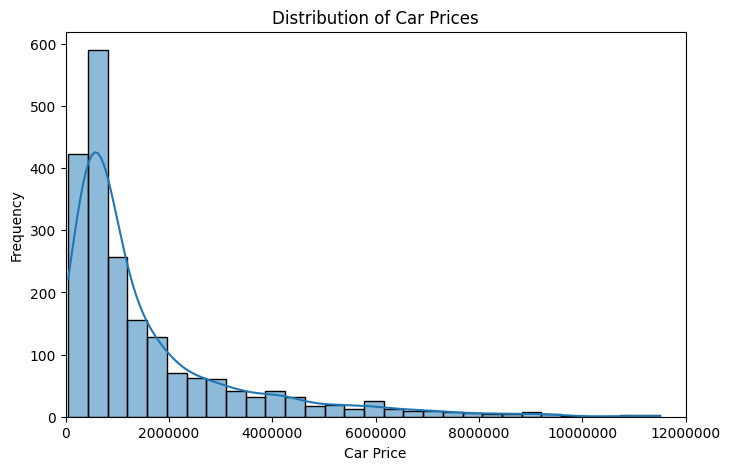

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(car['Price'], bins=30, kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 12000000)
plt.title('Distribution of Car Prices')
plt.xlabel('Car Price')
plt.ylabel('Frequency')
plt.show()

## Car Count by Company

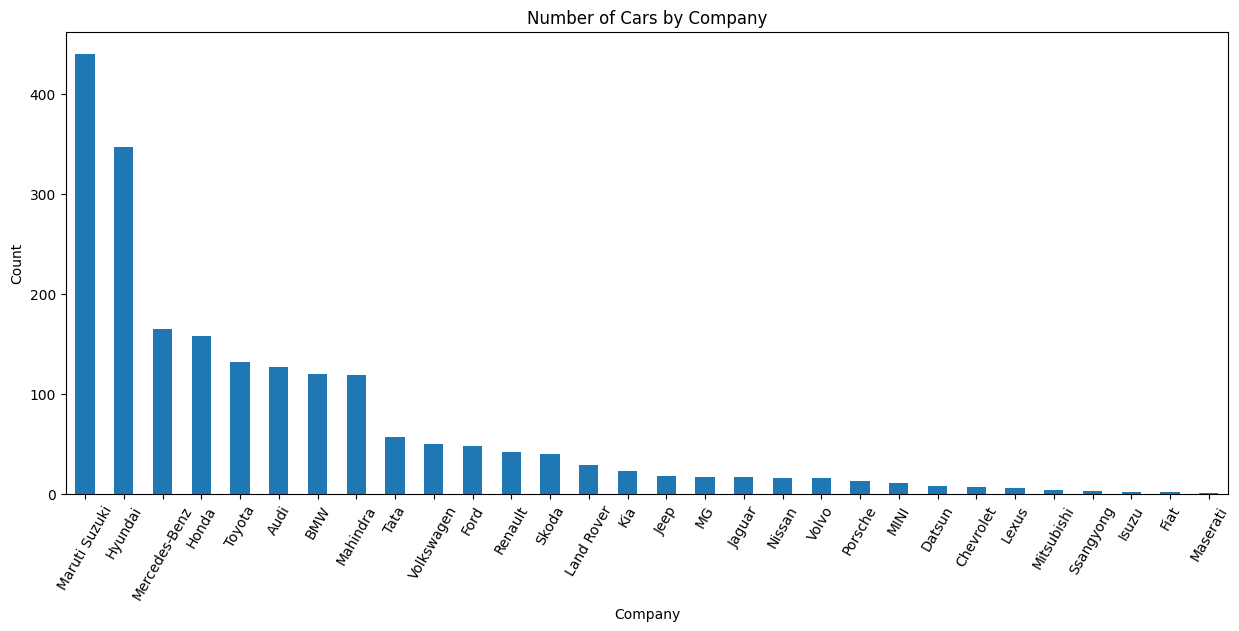

In [19]:
plt.figure(figsize=(15,6))
car['Company'].value_counts().plot(kind='bar')
plt.title('Number of Cars by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()


## Fuel Type vs Average Price

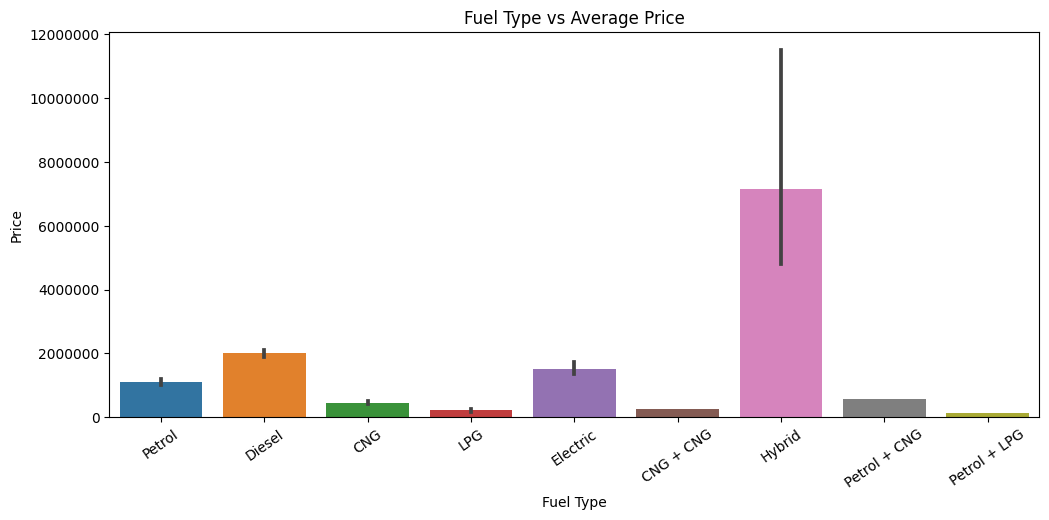

In [20]:
plt.figure(figsize=(12,5))
sns.barplot(x='Fuel Type', y='Price', data=car)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Fuel Type vs Average Price')
plt.xticks(rotation=35)
plt.show()

## Year vs Median Price (Trend)

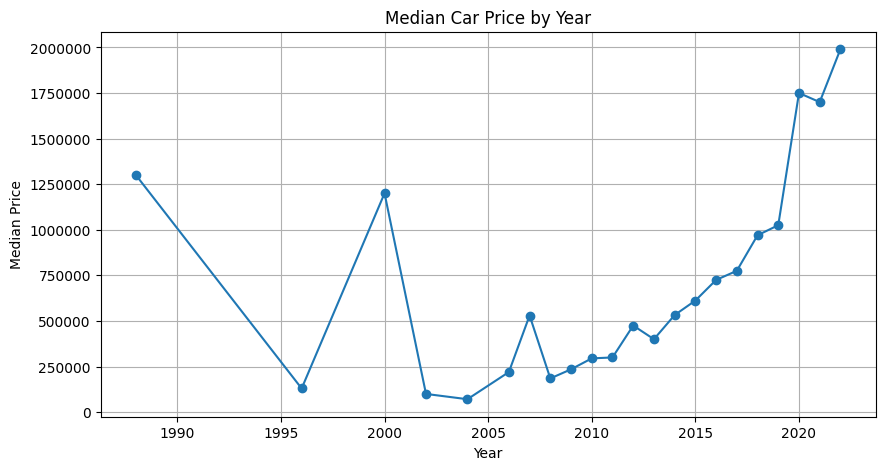

In [21]:
plt.figure(figsize=(10,5))
car.groupby('Year')['Price'].median().plot(marker='o')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Median Car Price by Year')
plt.ylabel('Median Price')
plt.xlabel('Year')
plt.grid(True)
plt.show()

## Kilometers Driven vs Price (scatter)

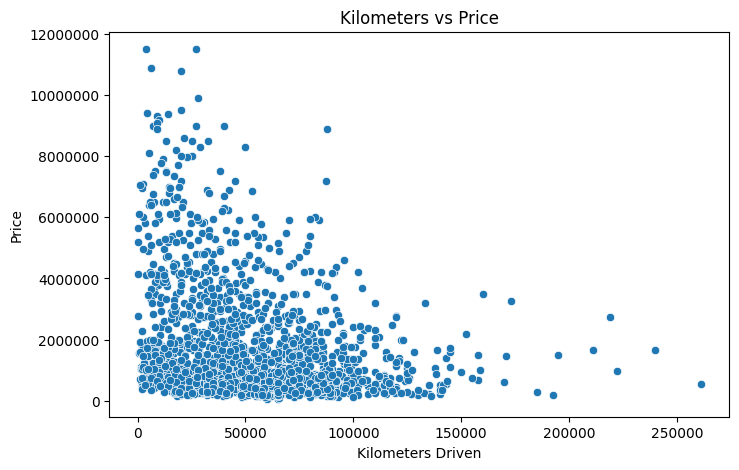

In [22]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Kilometer', y='Price', data=car)
plt.ticklabel_format(style='plain', axis='x') 
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.title('Kilometers vs Price')
plt.show()


### Engine Size vs Price (relationship)

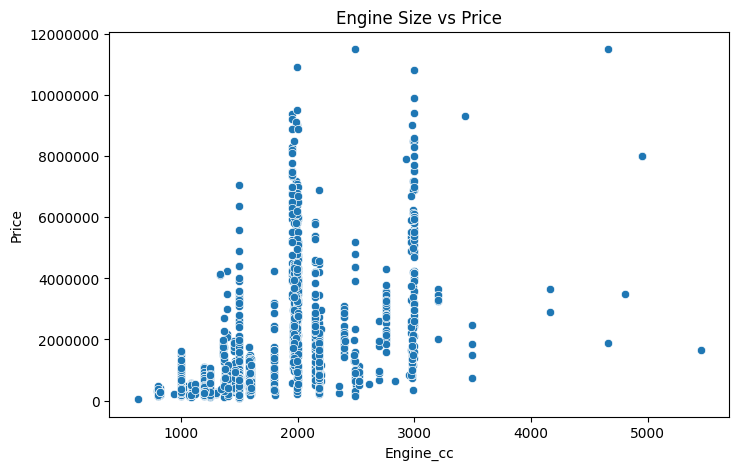

In [23]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Engine_cc', y='Price', data=car)
plt.ticklabel_format(style='plain', axis='x') 
plt.ticklabel_format(style='plain', axis='y')
plt.title('Engine Size vs Price')
plt.show()

### Correlation Heatmap (for numeric features)

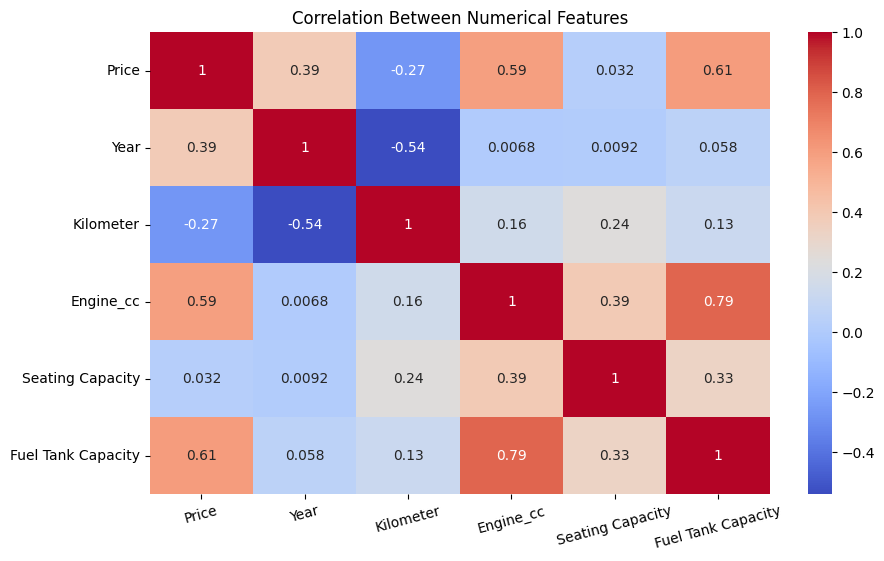

In [24]:
# Select only numeric columns
numeric_df = car.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.xticks(rotation=15)

plt.show()


# Model Building

## Selecting Features and Encoding

In [25]:
# Selecting features
X = car.drop(columns = ['Price'])
y = car['Price']

In [26]:
# One-hot encode all categorical columns
X = pd.get_dummies(X, drop_first=True)

## Train-Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Evaluation 

y_pred = model.predict(X_test)

lr_r2 = r2_score(y_test, y_pred)
lr_rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R² Score:", lr_r2)
print("RMSE:", lr_rmse)


R² Score: 0.8722386009739483
RMSE: 611761.5594238145


In [30]:
results = []

# Save result
results.append({
    'Model': 'Linear Regression',
    'R2 Score': round(lr_r2, 4),
    'RMSE': int(lr_rmse)
})

## Ridge and Lasso models

In [31]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

print("Ridge R²:", r2_score(y_test, ridge_preds))
print("Lasso R²:", r2_score(y_test, lasso_preds))

Ridge R²: 0.8857664873624771
Lasso R²: 0.8696037653135991


In [32]:
# Ridge Metrics
ridge_r2 = r2_score(y_test, ridge_preds)
ridge_rmse = mean_squared_error(y_test, ridge_preds, squared=False)

results.append({
    'Model': 'Ridge Regression',
    'R2 Score': round(ridge_r2, 4),
    'RMSE': int(ridge_rmse)
})

# Lasso Metrics
lasso_r2 = r2_score(y_test, lasso_preds)
lasso_rmse = mean_squared_error(y_test, lasso_preds, squared=False)

results.append({
    'Model': 'Lasso Regression',
    'R2 Score': round(lasso_r2, 4),
    'RMSE': int(lasso_rmse)
})

## Decision Tree

In [33]:
from sklearn.tree import DecisionTreeRegressor

# Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [34]:
# Predicting and evaluating
dt_preds = dt_model.predict(X_test)
dt_r2 = r2_score(y_test, dt_preds)
dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)

# Printing scores
print("Decision Tree R²:", round(dt_r2, 4))
print("Decision Tree RMSE:", int(dt_rmse))


Decision Tree R²: 0.8595
Decision Tree RMSE: 641509


In [35]:
# Saving performance to results
results.append({
    'Model': 'Decision Tree',
    'R2 Score': round(dt_r2, 4),
    'RMSE': int(dt_rmse)
})

## Random Forest Regression

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
# Predicting and evaluating
rf_preds = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)

# Printing scores
print("Random Forest R²:", round(rf_r2, 4))
print("Random Forest RMSE:", int(rf_rmse))


Random Forest R²: 0.9307
Random Forest RMSE: 450492


In [38]:
# Saving performance to results
results.append({
    'Model': 'Random Forest',
    'R2 Score': round(rf_r2, 4),
    'RMSE': int(rf_rmse)
})


## XGBoost Regressor

In [39]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

# Print scores
print("XGBoost R²:", round(xgb_r2, 4))
print("XGBoost RMSE:", int(xgb_rmse))


XGBoost R²: 0.9416
XGBoost RMSE: 413605


In [41]:
# Save performance to results
results.append({
    'Model': 'XGBoost',
    'R2 Score': round(xgb_r2, 4),
    'RMSE': int(xgb_rmse)
})


# Model Performance Summary

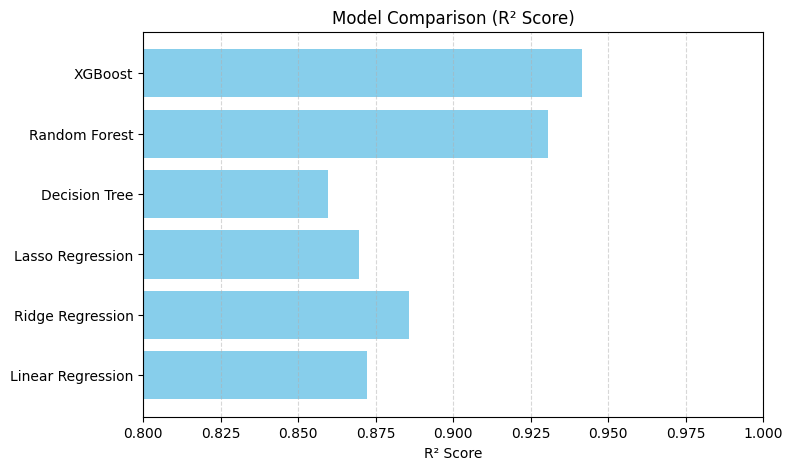

In [42]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Ploting R² Score for each model
plt.figure(figsize=(8, 5))
plt.barh(results_df['Model'], results_df['R2 Score'], color='skyblue')

plt.xlabel('R² Score')
plt.title('Model Comparison (R² Score)')
plt.xlim(0.8, 1)  # Optional: to focus on high-performing models
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

### 📊 Model Comparison Summary

After training and evaluating multiple models, here is the final performance summary:

| Model             | R² Score | RMSE    |
|------------------|----------|---------|
| XGBoost           | 0.9416   | 413,605 |
| Random Forest     | 0.9307   | 450,492 |
| Ridge Regression  | 0.8858   | 578,467 |
| Linear Regression | 0.8722   | 611,761 |
| Lasso Regression  | 0.8696   | 618,037 |
| Decision Tree     | 0.8595   | 641,509 |

**Conclusion**:  
XGBoost performed the best with the highest R² score and lowest RMSE, making it the final selected model.


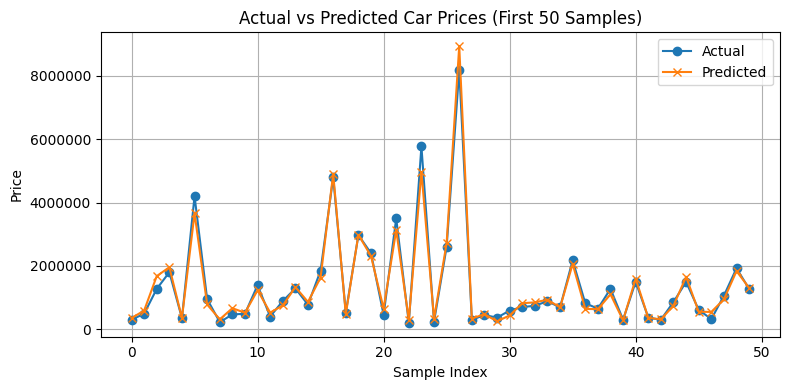

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(xgb_preds[:50], label='Predicted', marker='x')
plt.ticklabel_format(style='plain', axis='x') 
plt.ticklabel_format(style='plain', axis='y')
plt.title('Actual vs Predicted Car Prices (First 50 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving the XGB Model to deploy

In [44]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model, "xgb_car_model.pkl")

print("Model saved.")

Model saved.


### Made by - Harshit